## Validação de Experimentos

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from IPython.display import Image, display
from collections import defaultdict
import numpy as np
import pandas as pd
import os

In [48]:
clfs_list = []
for k in [3, 7, 15]:
  clfs_list.append(('KNN-{}'.format(k), KNeighborsClassifier(n_neighbors=k)))
  clfs_list.append(('W-KNN-{}'.format(k), KNeighborsClassifier(n_neighbors=k, weights='distance')))

clfs_list.append(('DecisionTree',DecisionTreeClassifier()))
clfs_list.append(('MultinomialNB', MultinomialNB()))




def run_experiment(X_, y_):
  metrics = defaultdict(lambda: [],{})
  exp_results = pd.DataFrame({'accuracy': [],'classifier_name':[],'fit_time':[]})
  cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=42)
  
  mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                      max_iter=10000,
                       warm_start=True,
                    hidden_layer_sizes=(15, np.unique(y_).size), random_state=1)
  clfs_list.append(('MLPClassifier', mlp))

  for clf in clfs_list:
    step = 1
    for _ in range(5):
        clf_name, estimator = clf
        scores = cross_validate(estimator, X_, y_, cv=cv,
                                scoring=('accuracy'),
                                return_train_score=False)
        exp_df = pd.DataFrame({
            'accuracy':scores['test_score'],
            'classifier_name':[clf_name for _ in range(10)],
            'fit_time':scores['fit_time']+scores['score_time'],
            'dataset_name':['dataset'+str(i) for i in range(step, step+10)]
        })
        step += 10
        exp_results = exp_results.append(exp_df)
 
  clfs_list.pop() 
  return exp_results.fillna(0)

### Base de Dados



In [49]:
# define the name of the directory to be created
IRIS_RESULTS = 'results/iris'
SEGMENT_RESULTS = 'results/segment'
WAVEFORM_RESULTS = 'results/waveform'

In [50]:
try:  
  os.makedirs(os.path.join(IRIS_RESULTS, 'brutos'))
  os.makedirs(os.path.join(IRIS_RESULTS, 'processados'))
  os.makedirs(os.path.join(SEGMENT_RESULTS, 'brutos'))
  os.makedirs(os.path.join(SEGMENT_RESULTS, 'processados'))
  os.makedirs(os.path.join(WAVEFORM_RESULTS, 'brutos'))
  os.makedirs(os.path.join(WAVEFORM_RESULTS, 'processados'))
except OSError:
    print ("Creation of the directories failed")
else:
    print ("Successfully created the directories")

Creation of the directories failed


### Baixando os dados da UCI-database

As bases de dados foram baixadas e enviadas para o meu repositório.

In [51]:
!git clone https://github.com/Tiagoblima/UCI-database.git

fatal: destination path 'UCI-database' already exists and is not an empty directory.


#### PRÉ-PROCESSAMENTO

O pré-processamento utilizado levou em consideração ao menos uma técnica. 
O objetivo principal foi melhor preparar os dados para a classificação utilizando o KNN.
1. Para o \textit{Iris dataset} foi realizada a normalização dos atributos entre os valores de 0 e 1 de todas as instâncias.
Sendo assim, a soma de todos os atributos são iguais a 1. Diferentemente da base de dados original, agora, teremos a proporção de cada atributo o que pode revelar a importância dele para classe em específico. 
Além disso, dados reais entre [0,1] ajudam a evitar possíveis distorções em relação aos atributos. 

2. Para as bases de dados \textit{Statlog (Image Segmentation)} e \textit{Waveform Database Generator} foi utilizada a análise do principal componente (\textit{PCA}). 
Isso permite que possamos reduzir a quantidade de atributos de cada instância e consequentemente reduzir o tempo de execução do algoritmo. 
Foram selecionados 4 componentes principais de cada conjunto de atributos relacionado as instâncias da base de dados.

Em todos os casos os resultados obtidos com dados pré-processados foram melhores do que com dados brutos.


### Iris Dataset 

O Iris dataset consiste de um conjunto de dados onde são

descritas a altura e a largura das sépalas e pétalas de 4 tipos de flores com um total de 150 exemplos. 

#### Dados Brutos

In [52]:
iris_data = pd.read_csv('UCI-database/iris.data', names=["feat1", "feat2", "feat3", "feat4", "class"], sep=",")
iris_data

,feat1,feat2,feat3,feat4,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


#### Pré-Processamento

Para o Iris dataset foi realizada a normalização dos atributos entre os valores de 0 e 1 de todas as instâncias.  Sendo assim, a soma de todos os atributos são iguais a 1.  Diferentemente dabase de dados original, agora, teremos a proporção de cada atributo o que pode revelar a importância dele para classe em específico. Além disso, dados reais entre [0,1] ajudam a evitar possíveis distorções em relação aos atributos. 

In [53]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [54]:
feats = ["feat1", "feat2", "feat3", "feat4"]
X = iris_data[feats]

# Normalizando os dados
X_normalized = preprocessing.normalize(X, norm='l2')
iris_data[["feat1", "feat2", "feat3", "feat4"]] = X_normalized
iris_data.to_csv(os.path.join(IRIS_RESULTS, 'processados/normalized_data.csv'), encoding='utf-8')
iris_data

,feat1,feat2,feat3,feat4,class
0,0.803773,0.551609,0.220644,0.031521,Iris-setosa
1,0.828133,0.507020,0.236609,0.033801,Iris-setosa
2,0.805333,0.548312,0.222752,0.034269,Iris-setosa
3,0.800030,0.539151,0.260879,0.034784,Iris-setosa
4,0.790965,0.569495,0.221470,0.031639,Iris-setosa
...,...,...,...,...,...
145,0.721557,0.323085,0.560015,0.247699,Iris-virginica
146,0.729654,0.289545,0.579090,0.220054,Iris-virginica
147,0.716539,0.330710,0.573231,0.220474,Iris-virginica
148,0.674671,0.369981,0.587616,0.250281,Iris-virginica


### Statlog (Image Segmentation)
A base de dados Statlog (Image Segmentation) é composta por segmentações feitas manualmente de 7 imagens que permitem a classificação pixel a pixel. 

In [55]:
segment_feats = ["feat"+str(1+n) for n in range(19)]

segment_data = pd.read_csv('UCI-database/segment.dat', names=segment_feats+['class'],sep=" ")
segment_data

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,class
0,218.0,178.0,9,0.111111,0.0,0.833333,0.547722,1.111109,0.544331,59.629630,52.444443,75.222220,51.222220,-21.555555,46.777780,-25.222221,75.222220,0.318996,-2.040554,6
1,113.0,130.0,9,0.000000,0.0,0.277778,0.250924,0.333333,0.365148,0.888889,0.000000,2.555556,0.111111,-2.666667,5.000000,-2.333333,2.555556,1.000000,-2.123254,3
2,202.0,41.0,9,0.000000,0.0,0.944448,0.772202,1.111112,1.025597,123.037040,111.888885,139.777790,117.444440,-33.444443,50.222220,-16.777779,139.777790,0.199347,-2.299918,2
3,32.0,173.0,9,0.000000,0.0,1.722222,1.781593,9.000000,6.749488,43.592594,39.555557,52.888890,38.333336,-12.111111,27.888890,-15.777778,52.888890,0.266914,-1.998858,6
4,61.0,197.0,9,0.000000,0.0,1.444444,1.515353,2.611111,1.925463,49.592594,44.222220,61.555557,43.000000,-16.111110,35.888890,-19.777779,61.555557,0.302925,-2.022274,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,30.0,102.0,9,0.000000,0.0,1.222222,0.118518,1.333333,0.800000,20.259260,20.333334,25.000000,15.444445,0.222222,14.222222,-14.444445,25.000000,0.381059,-1.555097,1
2306,143.0,24.0,9,0.000000,0.0,1.277777,0.907406,0.888888,1.140749,127.629630,117.666664,141.666670,123.555560,-29.888890,42.111110,-12.222222,141.666670,0.169397,-2.349252,2
2307,80.0,72.0,9,0.000000,0.0,1.222223,1.003697,1.444444,1.167461,59.000000,51.333332,74.444440,51.222220,-23.000000,46.333332,-23.333334,74.444440,0.314606,-2.090221,4
2308,98.0,133.0,9,0.000000,0.0,0.555555,0.172133,0.388889,0.327731,0.962963,0.000000,2.777778,0.111111,-2.888889,5.444445,-2.555556,2.777778,1.000000,-2.123254,3


##### Pré-processamento

In [56]:
# Normalizando os dados
X = segment_data[segment_feats].to_numpy()
X_scaled = preprocessing.normalize(X, norm='l2')
X_scaled.shape

(2310, 19)

In [57]:
from sklearn.preprocessing import MinMaxScaler
# Reduzindo as dimensões 
pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X_scaled)
scaler = MinMaxScaler()
reduced_X = scaler.fit_transform(reduced_X)
reduced_segment = pd.DataFrame(reduced_X, columns=feats)
reduced_segment["class"] = segment_data["class"]
reduced_segment.to_csv(os.path.join(SEGMENT_RESULTS, 'processados/reduced.csv'))
reduced_segment

,feat1,feat2,feat3,feat4,class
0,0.431308,0.552776,0.011500,0.539871,6
1,0.088325,0.559241,0.094695,0.379843,3
2,0.834952,0.561663,0.098774,0.309305,2
3,0.363960,0.099258,0.060764,0.483916,6
4,0.364246,0.172263,0.029233,0.504992,6
...,...,...,...,...,...
2305,0.292968,0.175380,0.035965,0.503839,1
2306,0.909239,0.471503,0.128853,0.223372,2
2307,0.713742,0.377697,0.032577,0.559829,4
2308,0.071421,0.499763,0.092937,0.383451,3


### Waveform Database
Cada instância em uma região 3x3 de uma imagem, são 2310 exemplos e 19 atributos de dados contínuos.
O dataset Waveform Database Generator contém dados relacionados a geração de três tipos de onda. 
São 21 atributos de dados contínuos que variam de 0 a 6 e 500 mil instâncias.

In [58]:
waveform_feats = ["feat"+str(1+n) for n in range(21)]

waveform_data = pd.read_csv('UCI-database/waveform.data', sep=',',names=waveform_feats+['class'])
waveform_data

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,class
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56,2
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42,1
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12,0
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12,1
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.65,0.69,2.29,-0.16,0.51,0.26,2.34,-0.42,0.49,0.31,...,3.46,4.81,5.49,5.19,3.10,3.86,2.96,1.09,-1.42,0
4996,-0.02,0.67,2.34,3.18,2.16,4.77,6.70,4.54,4.92,3.39,...,1.53,2.52,1.14,-1.56,-1.18,-0.56,0.02,-1.05,-0.18,1
4997,0.01,-1.99,0.16,2.30,-0.53,1.93,3.61,3.00,4.61,5.73,...,3.14,3.04,1.61,0.60,-0.52,0.62,1.00,1.21,-0.27,1
4998,-0.40,0.41,-0.48,1.04,0.79,-0.66,1.18,0.52,2.20,0.59,...,3.64,3.62,5.97,2.63,3.83,1.72,2.08,1.31,1.37,0


Para as bases de dados *Statlog (Image Segmentation)* e *Waveform Database Generator* além da normalização dos dados feita na base de dados do *Iris dataset* foi utilizada uma análise do principal componente (**PCA**) . 
Isso permite que possamos reduzir a quantidade de atributos, extraindo as informações mais relevante. 
Foram selecionados 4 componentes principais de cada conjunto de atributos relacionado as instâncias da base de dados.

#### Pré-processamento

In [59]:
waveform_data

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,class
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56,2
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42,1
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12,0
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12,1
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.65,0.69,2.29,-0.16,0.51,0.26,2.34,-0.42,0.49,0.31,...,3.46,4.81,5.49,5.19,3.10,3.86,2.96,1.09,-1.42,0
4996,-0.02,0.67,2.34,3.18,2.16,4.77,6.70,4.54,4.92,3.39,...,1.53,2.52,1.14,-1.56,-1.18,-0.56,0.02,-1.05,-0.18,1
4997,0.01,-1.99,0.16,2.30,-0.53,1.93,3.61,3.00,4.61,5.73,...,3.14,3.04,1.61,0.60,-0.52,0.62,1.00,1.21,-0.27,1
4998,-0.40,0.41,-0.48,1.04,0.79,-0.66,1.18,0.52,2.20,0.59,...,3.64,3.62,5.97,2.63,3.83,1.72,2.08,1.31,1.37,0


In [60]:
# Normalizando os dados
X = waveform_data[waveform_feats].to_numpy()
X_scaled = preprocessing.normalize(X, norm='l2')
X_scaled[:1]

array([[-0.09399613, -0.11921461, -0.13373433, -0.02139749,  0.04585177,
         0.16965156,  0.06495668,  0.01604812, -0.01528392,  0.06801346,
         0.08253319,  0.3209624 ,  0.2208527 ,  0.59225205,  0.35076605,
         0.2407218 ,  0.39126845,  0.25371314,  0.09170354,  0.01834071,
        -0.04279499]])

In [61]:
# Reduzindo as dimensões
pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X_scaled)
scaler = MinMaxScaler()
reduced_X = scaler.fit_transform(reduced_X)
reduced_waveform = pd.DataFrame(reduced_X, columns=feats)
reduced_waveform["class"] = waveform_data["class"]
reduced_waveform.to_csv(os.path.join(WAVEFORM_RESULTS, 'processados/reduced.csv'))
reduced_waveform

,feat1,feat2,feat3,feat4,class
0,0.847195,0.684239,0.789360,0.554251,2
1,0.238832,0.619837,0.572815,0.393722,1
2,0.269685,0.760054,0.518402,0.636537,0
3,0.340434,0.281444,0.510362,0.402951,1
4,0.381897,0.185665,0.570506,0.346243,1
...,...,...,...,...,...
4995,0.839634,0.772747,0.655460,0.414305,0
4996,0.125570,0.521982,0.661578,0.569736,1
4997,0.404999,0.210339,0.443713,0.661326,1
4998,0.817673,0.622929,0.654686,0.463304,0


### Algoritmo de Classificação (k-Vizinhos Mais Próximos)

Algoritmo de Classificação (k-Vizinhos Mais Próximos)
O algoritmo do k-Vizinhos Mais Próximos (k-Nearest Neighbors, ou k-NN) consiste em um
algoritmo supervisionado no qual a classificação de padrões desconhecidos é executada de
acordo com o processo descrito abaixo.
1. Dado um padrão de teste xi, representado como um vetor n-dimensional, cuja classe
deseja-se determinar, faça:
2. Encontre os k padrões xj do conjunto de treinamento mais próximos a xi, de acordo com
um critério de distância pré-estabelecido.
3. Encontre a classe c mais frequente (classe majoritária) entre os k vizinhos mais
próximos ao padrão xi, atribuindo o rótulo yc desta classe a xi (yi ← yc).

## EXPERIMENTOS

Os experimentos devem ser executados de acordo com o esquema abaixo para cada
uma das bases de dados adotadas (tanto as bases de dados brutos, quanto as bases de
dados pré-processadas):

i. Deve-se executar o 10-fold cross-validation 5 vezes para cada base de
dados, com cada uma das cinco execuções partindo de uma distribuição
aleatória dos dados entre cada fold, resultando em um total de 50
experimentos por base de dados (10 x 5).

ii. Em cada um dos 50 experimentos, os conjuntos de treinamento e teste
devem ser mantido o mesmo para cada algoritmo a ser testado (mesmo
ponto de partida para cada modelo), de modo a obter-se uma avaliação justa
dos resultados.

iii. O algoritmo a ser testado: k-Vizinhos Mais Próximos (K-NN).

iv. Deve-se testar o k-NN com os seguintes valores de tamanho da vizinhança:

k = 3, 5, 7, 9, 15.
v. A medida de distância adotada tanto no k-NN é a Distância Euclidiana,

### ANÁLISE EXPERIMENTAL
1. A comparação deve ser realizada em relação à Acurácia no Conjunto de Teste.
2. O tempo médio de execução dos algoritmos deve ser apresentado na tabela de
resultados.
3. Deve-se calcular a média, o desvio padrão e a mediana da Acurácia do Conjunto
de Teste para os 50 testes realizados para cada variação do algoritmo em cada base
de dados.

4. Uma análise comparativa entre as variações do algoritmo utilizado deve ser
realizada, de modo a identificar qual valor de k pode ser considerada a mais confiável
para a resolução dos problemas analisados.
5. Essa análise deve ser feita de forma empírica (baseado nas medidas obtidas) e através
do uso de algum teste de hipóteses estatístico (t de Student, Teste de Friedman,
ANOVA, etc.).

##### Baixando API para realização do teste de Hipótese

API realizar primeiro o teste de Friedman para verificar se todos os classificadores tem um desempenho equivalente ou não e em seguida constroi um gráfico mostrando o ranqueamento de cada classificador e quais tem um desempenho similar.

In [62]:
!git clone https://github.com/Tiagoblima/cd-diagram.git

fatal: destination path 'cd-diagram' already exists and is not an empty directory.


### Experimento Iris Dataset

#### Experimento Bases de Dados Brutos


In [63]:

iris_data = pd.read_csv('UCI-database/iris.data', names=["feat1", "feat2", "feat3", "feat4", "class"], sep=",")

X, y = iris_data[feats], iris_data['class']

result_df = run_experiment(X, y)

groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']

open(os.path.join(IRIS_RESULTS, 'brutos/result.txt'), 'w').write(summary.to_latex())
summary

,Média,Mediana,Desvio Padrão,Tempo Médio
classifier_name,,,,
DecisionTree,0.9384,0.94,0.030463,0.003001
KNN-15,0.9600,0.96,0.036140,0.005280
KNN-3,0.9580,0.96,0.022946,0.005856
KNN-7,0.9740,0.98,0.023990,0.006943
MLPClassifier,0.6060,0.61,0.360051,0.066562
MultinomialNB,0.7680,0.79,0.182991,0.003918
W-KNN-15,0.9680,0.97,0.030237,0.004361
W-KNN-3,0.9580,0.96,0.022946,0.004419
W-KNN-7,0.9720,0.98,0.024244,0.003838


##### Análise Empírica

O primeiro teste foi feito usando a base de dados bruta. 
Nele os classificadores conseguem obter um bom resultado apesar de não ter sido realizado o pré-processamento.
Em uma análise empírica fica claro que o classificador usando 5,9 e 15 vizinhos para classificação obtiveram resultados melhores do que os demais. 
Além disso, esse parâmetros permitiram que um tempo razoável fosse gasto na classificação. 

##### Teste Hipótese 

Quanto a teste de hipótese, a algoritmo KNN para o valor de k-vizinhos igual a 7 obtém o primeiro lugar no ranking de modelos. 
Os demais algoritmos obtém um resultado similares entre si.

Input file:  results/iris/brutos/result.csv
Output file:  results/iris/brutos/cd-diagram.png
['KNN-3' 'W-KNN-3' 'KNN-7' 'W-KNN-7' 'KNN-15' 'W-KNN-15' 'DecisionTree'
 'MultinomialNB' 'MLPClassifier']
Traceback (most recent call last):
  File "cd-diagram/main.py", line 414, in <module>
    main(sys.argv[1:])
  File "cd-diagram/main.py", line 410, in main
    draw_cd_diagram(df_perf=df_perf, title='Accuracy', labels=True, filename=outputfile)
  File "cd-diagram/main.py", line 286, in draw_cd_diagram
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)
  File "cd-diagram/main.py", line 346, in wilcoxon_holm
    p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
  File "C:\Users\Acer\anaconda3\lib\site-packages\scipy\stats\morestats.py", line 2964, in wilcoxon
    raise ValueError("zero_method 'wilcox' and 'pratt' do not "
ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.


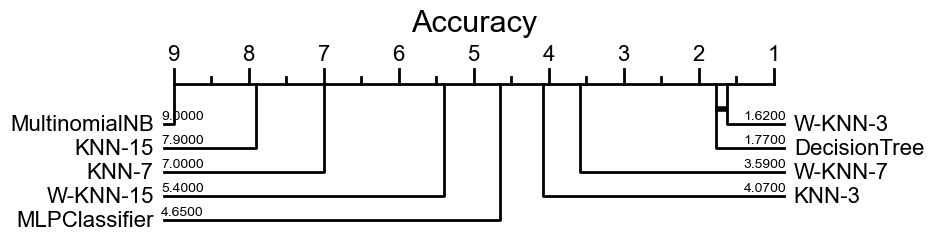

In [64]:
result_df.to_csv(os.path.join(IRIS_RESULTS,'brutos/result.csv'))
!python cd-diagram/main.py -i results/iris/brutos/result.csv -o results/iris/brutos/cd-diagram.png
display(Image('results/iris/brutos/cd-diagram.png'))

#### Base Pré-Processada

In [65]:
# Carregando os dados
iris_normalized = pd.read_csv(os.path.join(IRIS_RESULTS, 'processados/normalized_data.csv'))
X, y = iris_normalized[feats], iris_normalized['class']
metrics_iris2 = run_experiment(X, y)
result_df = pd.DataFrame.from_dict(metrics_iris2)

groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']
open(os.path.join(IRIS_RESULTS, 'processados/result.txt'), 'w').write(summary.to_latex())
summary

,Média,Mediana,Desvio Padrão,Tempo Médio
classifier_name,,,,
DecisionTree,0.9428,0.96,0.031301,0.003076
KNN-15,0.9760,0.98,0.023561,0.005079
KNN-3,0.9740,0.98,0.015779,0.005542
KNN-7,0.9720,0.98,0.020603,0.005896
MLPClassifier,0.2600,0.27,0.042378,0.006838
MultinomialNB,0.5440,0.59,0.133034,0.003400
W-KNN-15,0.9780,0.98,0.022946,0.003907
W-KNN-3,0.9720,0.98,0.018516,0.004098
W-KNN-7,0.9740,0.98,0.022223,0.004020


##### Análise Impirica 

Nesse experimento, fica claro uma melhora significativa na média de desempenho do classificador KNN para diferentes valores de k.
O algoritmo Decision Tree também teve uma melhora significativa.

##### Análise de Teste de Hipótese

Nesse caso, os classificadores obtiveram um resultado similar de acordo com o teste de hipótese.

Input file:  results/iris/processados/result.csv
Output file:  results/iris/processados/cd-diagram.png
['KNN-3' 'W-KNN-3' 'KNN-7' 'W-KNN-7' 'KNN-15' 'W-KNN-15' 'DecisionTree'
 'MultinomialNB' 'MLPClassifier']
DecisionTree     3.0
KNN-15           0.0
KNN-3            0.0
KNN-7            0.0
MLPClassifier    0.0
MultinomialNB    0.0
W-KNN-15         0.0
W-KNN-3          0.0
W-KNN-7          0.0
dtype: float64
MLPClassifier    9.00
MultinomialNB    8.00
DecisionTree     5.77
KNN-7            4.14
W-KNN-7          3.84
W-KNN-3          3.72
KNN-15           3.64
KNN-3            3.60
W-KNN-15         3.29
dtype: float64
('KNN-3', 'MLPClassifier', 5.25801184027132e-10, True)
('KNN-15', 'MLPClassifier', 6.081662569335683e-10, True)
('MLPClassifier', 'W-KNN-15', 6.081662569335683e-10, True)
('MLPClassifier', 'W-KNN-3', 6.081662569335683e-10, True)
('MLPClassifier', 'W-KNN-7', 6.259681887142859e-10, True)
('KNN-7', 'MLPClassifier', 6.442372696765328e-10, True)
('DecisionTree', 'MLPClassifier

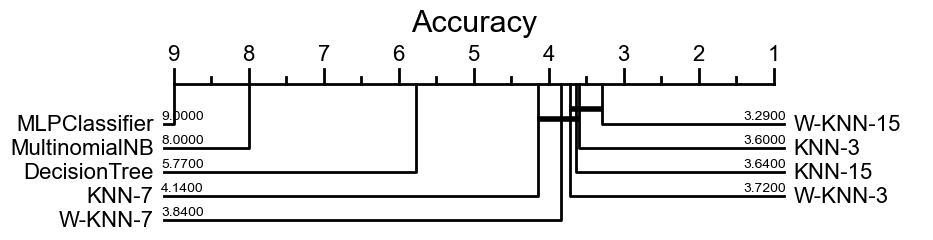

In [66]:
result_df.to_csv(os.path.join(IRIS_RESULTS, 'processados/result.csv'))
!python cd-diagram/main.py -i results/iris/processados/result.csv -o results/iris/processados/cd-diagram.png
display(Image('results/iris/processados/cd-diagram.png'))

### Statlog (Image Segmentation)

#### Base de dados Brutos

##### Análise Empírica

Em relação ao experimento usando a base de dados bruta, uma análise preliminar indica que o classificador com k igual a 3 tem um desempenho superior ao classificador usando outros valores para k-vizinhos, bem como supera de longe o algoritmo Decision Tree. 
Além de terem um uma acurácia média maior, ele apresenta resultados mais estáveis, tendo um menor desvio padrão. Além disso, eles gastam menos tempo. Portanto, com k igual 3 o classificador obtém um resultado superior os demais modelos.


In [67]:

header = ["feat"+str(1+n) for n in range(19)]
header.append('class')
segment_data = pd.read_csv('UCI-database/segment.dat', names=header,sep=" ")

X, y = segment_data[header[:-1]], segment_data['class']

result_df = run_experiment(X, y)

groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']
open(os.path.join(SEGMENT_RESULTS, 'brutos/result.txt'), 'w').write(summary.to_latex())
summary

,Média,Mediana,Desvio Padrão,Tempo Médio
classifier_name,,,,
DecisionTree,0.953028,0.951507,0.008446,0.017340
KNN-15,0.894758,0.897117,0.011235,0.050240
KNN-3,0.943644,0.943644,0.006067,0.051363
KNN-7,0.920970,0.920708,0.010084,0.049420
MLPClassifier,0.938794,0.938401,0.011297,8.797179
MultinomialNB,0.000000,0.000000,0.000000,0.003520
W-KNN-15,0.932503,0.930537,0.009441,0.037620
W-KNN-3,0.953080,0.952163,0.006371,0.025821
W-KNN-7,0.945085,0.947575,0.008650,0.028159


##### Teste Hipótese

A análise do teste hipótese indica que o modelo Decision Tree apresentar um desempenho superior enquanto o Kneighbors com k igual 3 é o segundo do rank.

Input file:  results/segment/brutos/result.csv
Output file:  results/segment/brutos/cd-diagram.png
['KNN-3' 'W-KNN-3' 'KNN-7' 'W-KNN-7' 'KNN-15' 'W-KNN-15' 'DecisionTree'
 'MultinomialNB' 'MLPClassifier']
DecisionTree     20.0
KNN-15            0.0
KNN-3             0.0
KNN-7             0.0
MLPClassifier     5.0
MultinomialNB     0.0
W-KNN-15          0.0
W-KNN-3          21.0
W-KNN-7           0.0
dtype: float64
MultinomialNB    9.00
KNN-15           7.90
KNN-7            7.00
W-KNN-15         5.40
MLPClassifier    4.63
KNN-3            4.06
W-KNN-7          3.64
DecisionTree     1.81
W-KNN-3          1.56
dtype: float64
('KNN-3', 'KNN-7', 6.442372696765328e-10, True)
('MultinomialNB', 'W-KNN-3', 6.442372696765328e-10, True)
('KNN-15', 'W-KNN-7', 6.822201844716231e-10, True)
('KNN-3', 'MultinomialNB', 6.822201844716231e-10, True)
('KNN-7', 'W-KNN-3', 6.822201844716231e-10, True)
('MultinomialNB', 'W-KNN-7', 6.822201844716231e-10, True)
('KNN-15', 'MLPClassifier', 7.019562041074612e-1

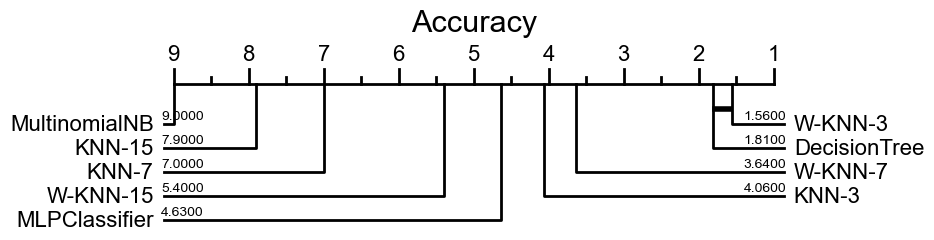

In [71]:
result_df.to_csv(os.path.join(SEGMENT_RESULTS, 'brutos/result.csv'))
!python cd-diagram/main.py -i results/segment/brutos/result.csv -o results/segment/brutos/cd-diagram.png
display(Image('results/segment/brutos/cd-diagram.png'))

#### Bases de Dados Preprocessada


##### Análise Empírica

Em relação ao experimento usando a base de dados pré-processada, uma análise preliminar indica que o classificador com k=3 e 5 tem um desempenho superior ao classificador usando 15 e 9 vizinhos e ainda mais superior ao modelo Decision Tree. 
Além de terem um uma acurácia média maior, eles apresentam resultados mais estáveis, tendo um menor desvio padrão. 
Além disso, eles gastam menos tempo. Portanto, com k=3 ou 5 o classificador obtém um resultado superior a quando k=15 e similar a quando k=5 e 7.
Todos os algoritmos apresentaram um resultado inferior ao teste anterior.


In [276]:
# Carregando os dados
reduced_segment = pd.read_csv(os.path.join(SEGMENT_RESULTS,'processados/reduced.csv'))
X, y = reduced_segment[feats], reduced_segment['class']
reduced_segment2 = run_experiment(X, y)

result_df = pd.DataFrame.from_dict(reduced_segment2)

groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']
open(os.path.join(SEGMENT_RESULTS, 'processados/result.txt'), 'w').write(summary.to_latex())
summary

,Média,Mediana,Desvio Padrão,Tempo Médio
classifier_name,,,,
DecisionTree,0.816750,0.816514,0.008745,0.008394
KNN-15,0.784404,0.789646,0.020699,0.028444
KNN-3,0.843644,0.847969,0.014743,0.025940
KNN-7,0.819528,0.823067,0.016430,0.026868
MLPClassifier,0.627654,0.648100,0.129098,2.307945
MultinomialNB,0.415334,0.422674,0.040080,0.003060
W-KNN-15,0.840236,0.834207,0.017317,0.009246
W-KNN-3,0.860026,0.865007,0.014403,0.006246
W-KNN-7,0.855177,0.852556,0.014722,0.007278


##### Teste Hipótese

A análise do teste hipótese a seguir indicar que o KNeighbohrs apresentar um desempenho superior com k=3 sendo o 1 do rank. 

Input file:  results/segment/processados/result.csv
Output file:  results/segment/processados/cd-diagram.png
['KNN-3' 'W-KNN-3' 'KNN-7' 'W-KNN-7' 'KNN-15' 'W-KNN-15' 'DecisionTree'
 'MultinomialNB' 'MLPClassifier']
DecisionTree      0.0
KNN-15            0.0
KNN-3             0.0
KNN-7             0.0
MLPClassifier     0.0
MultinomialNB     0.0
W-KNN-15          0.0
W-KNN-3          30.0
W-KNN-7          20.0
dtype: float64
MultinomialNB    8.80
MLPClassifier    7.80
KNN-15           7.10
DecisionTree     5.59
KNN-7            5.43
W-KNN-15         3.62
KNN-3            3.41
W-KNN-7          1.85
W-KNN-3          1.40
dtype: float64
('KNN-15', 'KNN-3', 7.019562041074612e-10, True)
('KNN-15', 'W-KNN-15', 7.019562041074612e-10, True)
('KNN-15', 'W-KNN-7', 7.019562041074612e-10, True)
('KNN-3', 'MultinomialNB', 7.019562041074612e-10, True)
('KNN-3', 'W-KNN-3', 7.019562041074612e-10, True)
('KNN-7', 'W-KNN-15', 7.019562041074612e-10, True)
('KNN-7', 'W-KNN-7', 7.019562041074612e-10, True)


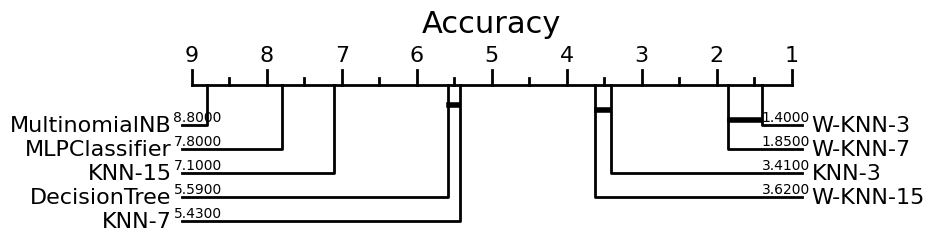

In [277]:
result_df.to_csv(os.path.join(SEGMENT_RESULTS, 'processados/result.csv'))
!python cd-diagram/main.py -i results/segment/processados/result.csv -o results/segment/processados/cd-diagram.png
display(Image('results/segment/processados/cd-diagram.png'))

### Experimento Waveform

#### Base de Dados Brutos

##### Análise Empírica

Em uma análise empírica usando a base de dados brutos, é possível observar que nenhum dos classificadores apresentou um bom desempenho.
Os melhores resultados são obtidos com k igual a 9 e 15. 
O teste de hipótese confirma a análise inicial em que o KNN tem um resultado melhor com k igual a 15.



In [278]:
# Carregando Base Waveform

header = ["feat"+str(1+n) for n in range(21)]
header.append('class')
waveform_data = pd.read_csv('UCI-database/waveform.data', names=header, sep=",")
X, y = waveform_data[feats], waveform_data['class']

result_df = run_experiment(X, y)

groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']

open(os.path.join(WAVEFORM_RESULTS, 'brutos/result.txt'), 'w').write(summary.to_latex())
summary


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFa

,Média,Mediana,Desvio Padrão,Tempo Médio
classifier_name,,,,
DecisionTree,0.438061,0.441212,0.012365,0.019341
KNN-15,0.493515,0.490303,0.009672,0.065842
KNN-3,0.463091,0.463636,0.007639,0.056769
KNN-7,0.479091,0.479091,0.009213,0.060671
MLPClassifier,0.502121,0.502727,0.013313,3.438021
MultinomialNB,0.000000,0.000000,0.000000,0.002401
W-KNN-15,0.498788,0.496061,0.011677,0.023832
W-KNN-3,0.465212,0.465152,0.006818,0.013978
W-KNN-7,0.484545,0.483333,0.010898,0.017850


##### Teste Hipótese

O teste de hipótese confirma a análise inicial em que o KNN tem um resultado melhor com k=15.

Input file:  results/waveform/brutos/result.csv
Output file:  results/waveform/brutos/cd-diagram.png
['KNN-3' 'W-KNN-3' 'KNN-7' 'W-KNN-7' 'KNN-15' 'W-KNN-15' 'DecisionTree'
 'MultinomialNB' 'MLPClassifier']
DecisionTree      0.0
KNN-15            0.0
KNN-3             0.0
KNN-7             0.0
MLPClassifier    25.0
MultinomialNB     0.0
W-KNN-15         25.0
W-KNN-3           0.0
W-KNN-7           0.0
dtype: float64
MultinomialNB    9.00
DecisionTree     8.00
KNN-3            6.70
W-KNN-3          6.20
KNN-7            5.05
W-KNN-7          3.75
KNN-15           2.95
MLPClassifier    1.75
W-KNN-15         1.60
dtype: float64
('KNN-15', 'W-KNN-15', 6.259681887142859e-10, True)
('KNN-3', 'KNN-7', 6.442372696765328e-10, True)
('MultinomialNB', 'W-KNN-3', 6.629842731757234e-10, True)
('KNN-15', 'MultinomialNB', 6.822201844716231e-10, True)
('KNN-15', 'KNN-7', 7.019562041074612e-10, True)
('KNN-3', 'MLPClassifier', 7.019562041074612e-10, True)
('KNN-7', 'W-KNN-15', 7.019562041074612e-10, Tr

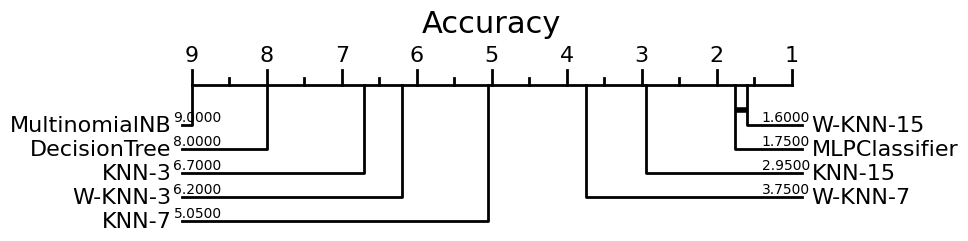

In [279]:
result_df.to_csv(os.path.join(WAVEFORM_RESULTS, 'brutos/result.csv'))
!python cd-diagram/main.py -i results/waveform/brutos/result.csv -o results/waveform/brutos/cd-diagram.png
display(Image('results/waveform/brutos/cd-diagram.png'))

#### Base Processada

##### Análise Empírica

Em um análise posterior, usando a base de dados pré-processada é possível ver que o algoritmo de classificação melhora de maneira substância para todos os valores de k e também para o algoritmo Decision Tree. 

In [280]:

# Carregando os dados
reduced_waveform = pd.read_csv(os.path.join(WAVEFORM_RESULTS, 'processados/reduced.csv'))
X, y = reduced_waveform[feats], reduced_waveform['class']
result_df = run_experiment(X, y)

groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']

open(os.path.join(WAVEFORM_RESULTS, 'processados/result.txt'), 'w').write(summary.to_latex())
summary

,Média,Mediana,Desvio Padrão,Tempo Médio
classifier_name,,,,
DecisionTree,0.809430,0.807879,0.007990,0.016071
KNN-15,0.847636,0.847879,0.005918,0.062543
KNN-3,0.828909,0.828485,0.004338,0.055878
KNN-7,0.838000,0.837879,0.004321,0.058215
MLPClassifier,0.338303,0.341818,0.008679,0.017511
MultinomialNB,0.730242,0.739697,0.027249,0.003267
W-KNN-15,0.845939,0.847576,0.005556,0.020821
W-KNN-3,0.826970,0.826970,0.004261,0.012952
W-KNN-7,0.834970,0.835152,0.003643,0.015821


##### Teste de Hipótese

Além disso, o melhor valor para k continua sendo k igual a 15 de acordo com o teste de hipótese e média obtida na tabela de resultados.

Input file:  results/waveform/processados/result.csv
Output file:  results/waveform/processados/cd-diagram.png
['KNN-3' 'W-KNN-3' 'KNN-7' 'W-KNN-7' 'KNN-15' 'W-KNN-15' 'DecisionTree'
 'MultinomialNB' 'MLPClassifier']
DecisionTree      0.0
KNN-15           35.0
KNN-3             0.0
KNN-7             5.0
MLPClassifier     0.0
MultinomialNB     0.0
W-KNN-15          5.0
W-KNN-3           0.0
W-KNN-7           0.0
dtype: float64
MLPClassifier    9.00
MultinomialNB    8.00
DecisionTree     6.97
W-KNN-3          5.67
KNN-3            4.96
W-KNN-7          4.05
KNN-7            3.15
W-KNN-15         1.90
KNN-15           1.30
dtype: float64
('KNN-3', 'W-KNN-15', 6.259681887142859e-10, True)
('KNN-7', 'W-KNN-3', 6.442372696765328e-10, True)
('W-KNN-15', 'W-KNN-7', 6.442372696765328e-10, True)
('KNN-3', 'MLPClassifier', 6.822201844716231e-10, True)
('KNN-7', 'MLPClassifier', 7.019562041074612e-10, True)
('MLPClassifier', 'W-KNN-3', 7.019562041074612e-10, True)
('MultinomialNB', 'W-KNN-15', 7.0

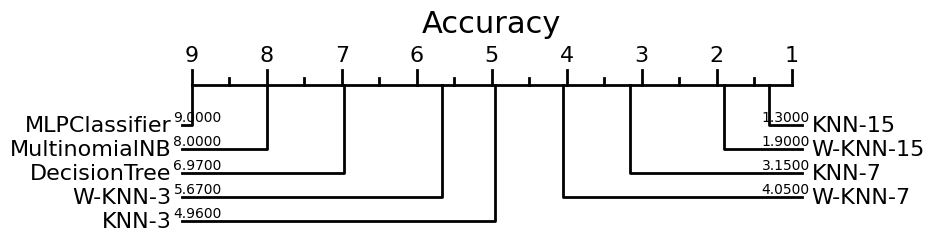

In [281]:
result_df.to_csv(os.path.join(WAVEFORM_RESULTS, 'processados/result.csv'))
!python cd-diagram/main.py -i results/waveform/processados/result.csv -o results/waveform/processados/cd-diagram.png
display(Image('results/waveform/processados/cd-diagram.png'))

### Referências 

@article{IsmailFawaz2018deep,
  Title                    = {Deep learning for time series classification: a review},
  Author                   = {Ismail Fawaz, Hassan and Forestier, Germain and Weber, Jonathan and Idoumghar, Lhassane and Muller, Pierre-Alain},
  journal                  = {Data Mining and Knowledge Discovery},
  Year                     = {2019},
  volume                   = {33},
  number                   = {4},
  pages                    = {917--963},
}

@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}